In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from custom_functions import processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import statistics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import data
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\gait_posture.xlsx'
dataset = pd.read_excel(file_path)
#dataset = dataset.drop(['Foldername'], axis=1)
dataset.head()

,AvgSpeed,CycleVariability,DoubleStance,MeanStepDuration,RoliTronc,Springiness,Sturdiness,Smoothness,Steadiness,Stability,...,critical_displacement_Diffusion_AP_YO,short_time_scaling_Diffusion_AP_YO,long_time_scaling_Diffusion_AP_YO,Frailty_Score,Frailty_State,Fried_Score,Fried_State,FROPCOM0023,SPPB9,SF3603_SCORE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.347786,0.773768,0.250704,7,0,2,0,0.0,17.80,30.0
1,0.880744,0.197969,0.229752,0.564857,0.096065,0.279714,-2.346519,-0.765797,-0.923574,1.968214,...,0.506507,0.840453,0.208258,4,1,3,1,1.0,18.75,22.0
2,1.247801,0.196011,0.254313,0.500417,0.387144,0.706152,-1.213314,-0.587174,0.820538,-0.728560,...,0.161995,0.842991,0.065370,9,0,2,0,0.0,18.86,29.0
3,0.942554,0.233782,0.208736,0.585556,0.100685,0.080144,-1.633020,-0.009619,0.594280,1.739947,...,1.660041,0.871164,0.168832,7,0,2,0,0.0,16.88,29.0
4,1.123115,0.229497,0.257278,0.563333,0.143611,0.375284,-0.206021,-0.733068,-0.058489,-0.218821,...,4.860132,0.838219,-0.295727,8,0,1,0,0.0,12.86,29.0


In [3]:
# Models
models = {
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=2.7),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
}

# Hyperparameters
params = {
    'DecisionTree': {
        'max_depth': [5, 7, 10],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy', 'log_loss']
    },


    'XGBoost': {
        'n_estimators': [30, 50,100],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [ 5, 7, 10],
        'min_child_weight': [1, 2, 4],
        },

    'RandomForest': {
        'n_estimators': [30, 50, 100],
        'max_depth': [5, 8, 10],
        'max_features': ['sqrt', 'log2', None],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
    }
}

Performing Grid Search for DecisionTree...
Performing Grid Search for XGBoost...
Performing Grid Search for RandomForest...
Performing Grid Search for DecisionTree...
Performing Grid Search for XGBoost...
Performing Grid Search for RandomForest...
Performing Grid Search for DecisionTree...
Performing Grid Search for XGBoost...
Performing Grid Search for RandomForest...
Performing Grid Search for DecisionTree...
Performing Grid Search for XGBoost...
Performing Grid Search for RandomForest...
Performing Grid Search for DecisionTree...
Performing Grid Search for XGBoost...
Performing Grid Search for RandomForest...
Model: DecisionTree
Average f1_score: 0.675671293618662, 0.12256510331484852
Average rec_score: 0.6810526315789474, 0.1040455898370658
Average roc_auc_score: 0.7171428571428572, 0.13539435975350383
Model: XGBoost
Average f1_score: 0.7007368421052631, 0.09361884177144066
Average rec_score: 0.7105263157894737, 0.08993688152965823
Average roc_auc_score: 0.7532380952380952, 0.12320

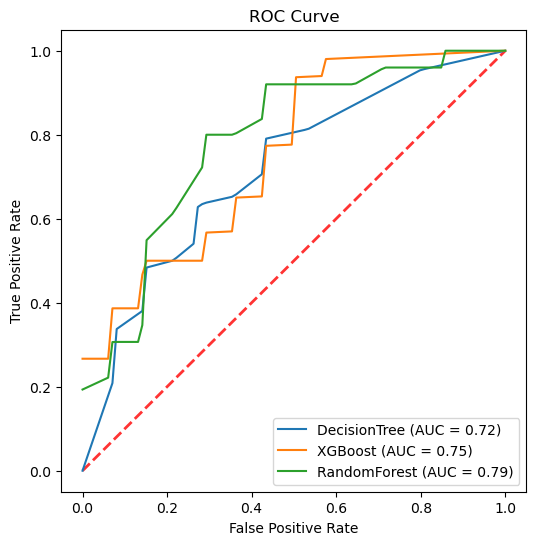

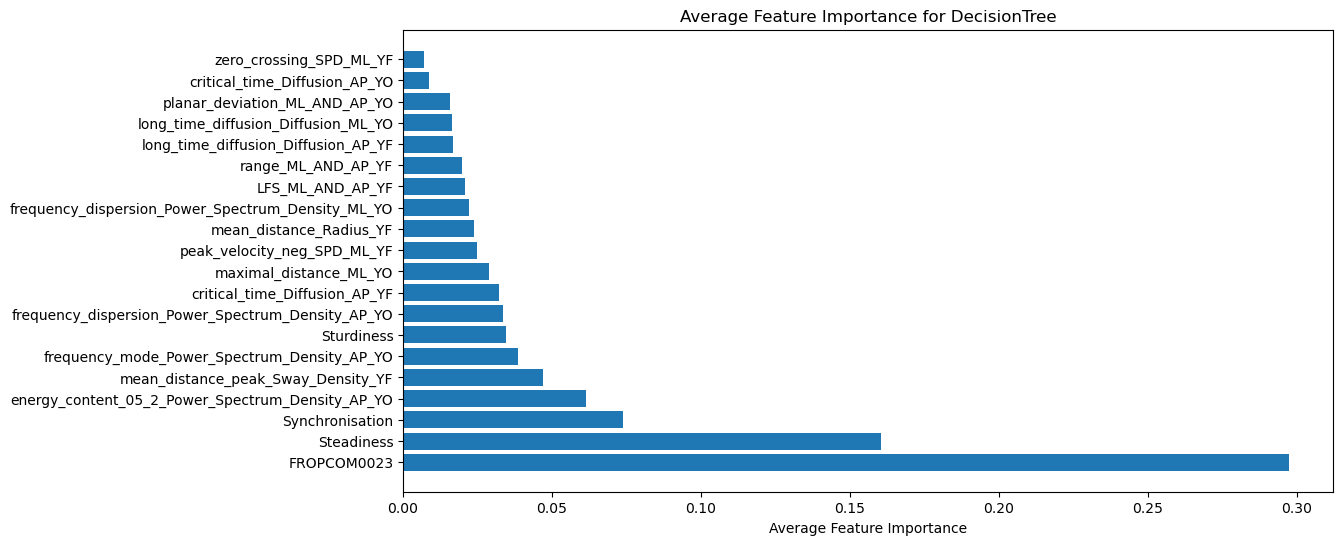

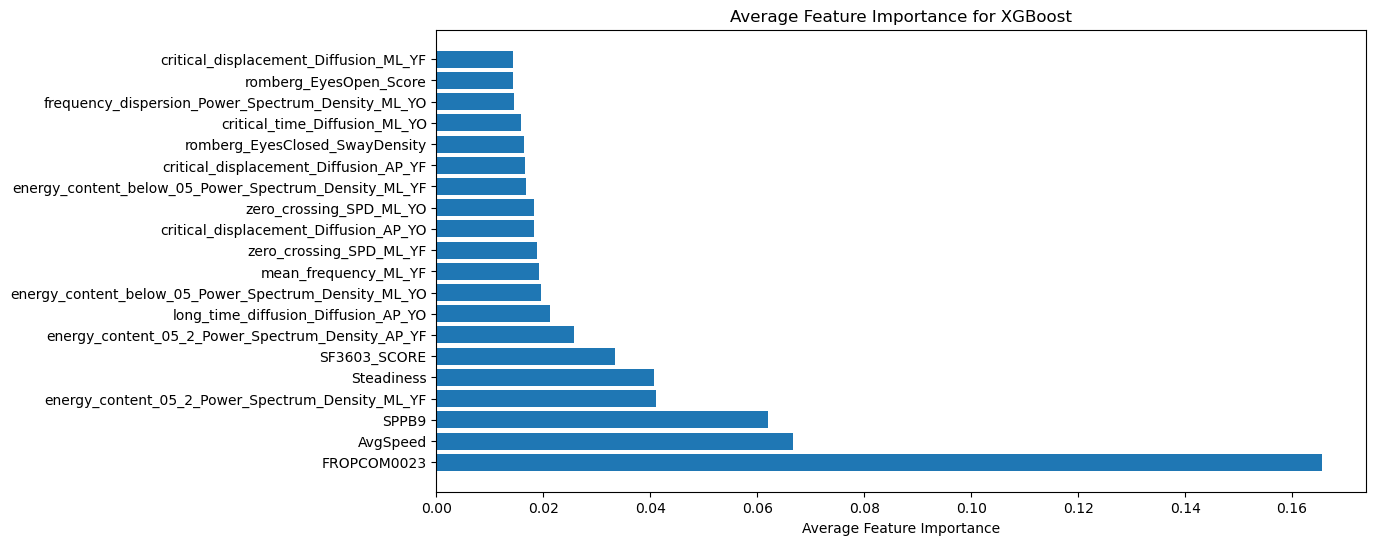

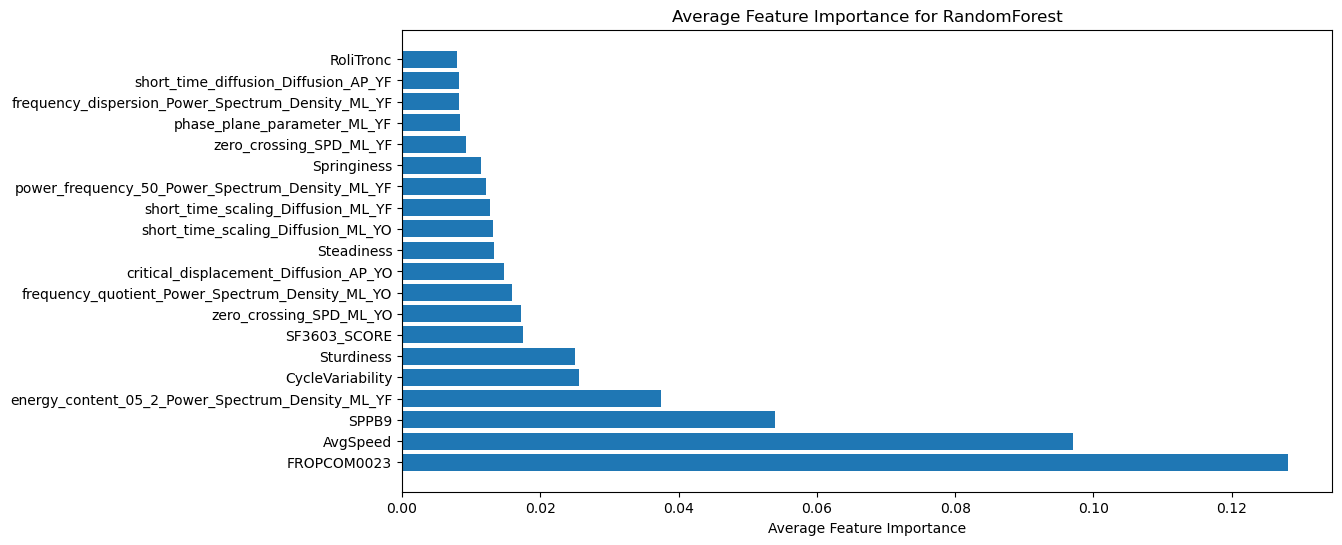

In [4]:
# Split data
# Use StratifiedKFold to split data into 5 folds and impute missing values

n_splits = 5

model_metrics = {}
best_model_params = {}
tpr_dict = {}  
feature_importances = {model_name: [] for model_name in models.keys()}


# Features names for 'feature_importances_' attributes
feature_names = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1)

# Features
X = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1).values

# Target variable
y = dataset['Frailty_State'].values

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each Fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    X_test_imputed, best_k = processing(X_test, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    # Loop through each model and perform grid
    for model_name, model in models.items():
        print(f'Performing Grid Search for {model_name}...')

        # Grid search
        grid_search = GridSearchCV(estimator=model, 
                                   param_grid=params[model_name], 
                                   scoring='roc_auc',
                                   cv=5, 
                                   n_jobs=-1, 
                                   verbose=0)

        # Initialize the metrics for the current model 
        if model_name not in model_metrics:
            model_metrics[model_name] = {'f1_score': [], 
                                         'rec_score': [], 
                                         'roc_auc_score': [],
                                         }
            
        # Initialize the best parameters and best model for the current model
        if model_name not in best_model_params:
            best_model_params[model_name] = {'best_params': [], 
                                             'best_models': []
                                             }

        grid_search.fit(X_train_imputed, y_train)

        # Best parameters
        best_params = grid_search.best_params_
        #print(f'Best Parameters: {best_params}')

        # Best score
        best_score = grid_search.best_score_
        #print(f'Best Score: {best_score}')

        # Best model
        best_model = grid_search.best_estimator_
        #print(f'Best Model: {best_model}')
        
        # Store the best parameters and model
        best_model_params[model_name]['best_params'].append(best_params)
        
        best_model_params[model_name]['best_models'].append(best_model)

        # Predictions
        y_pred = best_model.predict(X_test_imputed)

        # Calculate metrics
        y_pred_proba = best_model.predict_proba(X_test_imputed)[:, 1]

        model_metrics[model_name]['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))

        model_metrics[model_name]['rec_score'].append(recall_score(y_test, y_pred, average='weighted'))

        model_metrics[model_name]['roc_auc_score'].append(roc_auc_score(y_test, y_pred_proba))

        
        # Update TPR list for the model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if model_name not in tpr_dict:
          tpr_dict[model_name] = []
        tpr_dict[model_name].append(np.interp(np.linspace(0, 1, 100), fpr, tpr))


        # If the model has feature importances, store them
        if hasattr(best_model, 'feature_importances_'):
          feature_importances[model_name].append(best_model.feature_importances_)


# Calculate average and std metrics over all folds
for model_name in models.keys():
    for metric in model_metrics[model_name]:
        average_metric = sum(model_metrics[model_name][metric]) / n_splits
        std_metric = statistics.stdev(model_metrics[model_name][metric]) if len(model_metrics[model_name][metric]) > 1 else 0.0
        model_metrics[model_name][metric] = {'average': average_metric, 'std': std_metric}

# Display metrics
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics.items():
        print(f"Average {metric}: {values['average']}, {values['std']}")
        print("=" * 30)

# Calculate average TPR over all folds
average_tpr_dict = {}
for model_name in models.keys():
    sum_tpr = np.sum(np.array(tpr_dict[model_name]), axis=0)
    average_tpr = sum_tpr / n_splits
    average_tpr[-1] = 1.0  # ensure the curve ends at 1
    average_tpr_dict[model_name] = average_tpr

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

for model_name, average_tpr in average_tpr_dict.items():
    average_fpr = np.linspace(0, 1, 100)  # consistent with your np.linspace in the loop
    average_auc = np.trapz(average_tpr, average_fpr)  # Trapezoidal rule for AUC
    plt.plot(average_fpr, average_tpr, label=f"{model_name} (AUC = {average_auc:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Calculate average feature importances and plot them
for model_name, importances in feature_importances.items():
  avg_importance = np.mean(importances, axis=0)
  sorted_idx = np.argsort(avg_importance)[::-1][:20]  # top 20 features

  plt.figure(figsize=(12, 6))
  plt.barh(range(20), avg_importance[sorted_idx])
  plt.yticks(range(20), np.array(feature_names.columns)[sorted_idx])
  plt.xlabel('Average Feature Importance')
  plt.title(f'Average Feature Importance for {model_name}')
  plt.show()




In [18]:
from sklearn.feature_selection import RFECV

def best_features(model, X_train, y_train, data):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

    rfecv.fit(X_train, y_train)

    print("Optimal number of features : %d" % rfecv.n_features_)

    print('Selected features: %s' % list(data.columns[rfecv.support_]))

    plt.figure(figsize=(12, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (roc_auc)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    # Reframe the selected feature dataset
    selected_features = rfecv.get_support(1)
    X_selected_features = data[data.columns[selected_features]]

    return X_selected_features







In [ ]:
selected_features_per_model = {}

for model_name, model_param in best_model_params.items():
    print(f"Evaluating best features for {model_name}...")

    model_param = best_model_params[model_name]

    # the first one in the list is the best model
    best_model = model_param['best_models'][0]

    X_selected_features = best_features(best_model, X_train_imputed, y_train, feature_names)

    # Store the selected features
    selected_features_per_model[model_name] = X_selected_features.columns.tolist()




In [12]:
print(metrics)

{'f1_score': {'average': 0.651006335282651, 'std': 0.06860506469567665}, 'rec_score': {'average': 0.6405263157894736, 'std': 0.07994111406186134}, 'roc_auc_score': {'average': 0.6606666666666667, 'std': 0.055012470241629544}}


In [14]:
metriki = model_metrics['XGBoost']
print(metriki)

{'f1_score': {'average': 0.6931768501714056, 'std': 0.09954750945860939}, 'rec_score': {'average': 0.7000000000000001, 'std': 0.09661873552992538}, 'roc_auc_score': {'average': 0.7675238095238096, 'std': 0.10839082723446405}}
